# Char-RNN

In [1]:
%matplotlib inline

import os
import sys
import random
import numpy as np

from itertools import chain
from IPython.display import SVG
from hyperdash import Experiment
from contextlib import redirect_stdout, redirect_stderr

In [2]:
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential, load_model
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, one_hot
from keras.utils import to_categorical, print_summary, plot_model, Sequence
from keras.layers import LSTM, CuDNNLSTM, Dense, TimeDistributed, Activation, GRU

/home/s_belyaev/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Args

In [3]:
GPU_ACTIVE = False

## Load

In [4]:
%store -r edescs
descs = edescs
len(descs)

171161

In [5]:
random.sample(descs, 10)

['a playbook, a stub, freeipa, ipa, no variables | This function is really a stub, it could return variables to be used in DCNL a playbook. However, at this point there are no variables stored in DCNL FreeIPA/IPA. DCNL This function expects one string, this hostname to lookup variables for.',
 'attribute, cname, set cname, value, value attributes | Set cname and value attributes.',
 'chunk, chunks, diff, parent diff, replace | Testing DiffChunkGenerator.get_chunks with replace chunks in DCNL added file with parent diff',
 "a l{deferred, connection notification, iconnector.connect, instance\\, l{twisted.internet.interfaces | Connection notification. DCNL @return: A L{Deferred} that fires when this instance\\'s DCNL L{twisted.internet.interfaces.IConnector.connect} method DCNL is called. DCNL @rtype: L{Deferred}",
 'a change, a stage, models, swagger, the swagger file | Helper method to clean up resources and models if we detected a change in the swagger file DCNL for a stage',
 'item, t

In [6]:
MAX_SEQ_LEN = max(len(desc) for desc in descs)
MAX_SEQ_LEN

752

## Preprocessing

In [7]:
def chars_split(descs):
    chars = list(set(chain.from_iterable(desc for desc in descs)))
    char_ix = {char:ix for ix, char in enumerate(chars)}
    ix_char = {ix:char for ix, char in enumerate(chars)}
    descs = [[char_ix[char] for char in desc] for desc in descs]
    return descs, char_ix, ix_char

In [8]:
%time descs, dir_map, rev_map = chars_split(descs)
list(dir_map.items())[:5], list(rev_map.items())[:5]

CPU times: user 2.66 s, sys: 48 ms, total: 2.7 s
Wall time: 2.71 s


([('r', 0), ('y', 1), ('@', 2), ('+', 3), ('4', 4)],
 [(0, 'r'), (1, 'y'), (2, '@'), (3, '+'), (4, '4')])

In [9]:
VOCAB_SIZE = len(dir_map)
VOCAB_SIZE

95

## TT prepare

In [10]:
BATCH_SIZE = 64

In [11]:
class TTSequence(Sequence):
    def __init__(self):
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(descs) / BATCH_SIZE))
    
    def __getitem__(self, idx):
        batch_ids = self._ids[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
        seq_len = max(len(descs[di]) for di in batch_ids)
        X = np.zeros((BATCH_SIZE, seq_len, VOCAB_SIZE))
        y = np.zeros_like(X)
        
        for bi, di in enumerate(batch_ids):
            for pi, wi in enumerate(descs[di]):
                X[bi, seq_len - len(descs[di]) + pi, wi] = 1
            
            for pi, wi in enumerate(descs[di][1:]):
                y[bi, seq_len - len(descs[di]) + pi, wi] = 1
        
        return X, y
    
    def on_epoch_end(self):
        """Generate new shuffle in between epochs."""
        self._ids = np.random.permutation(len(descs))

In [12]:
tts = TTSequence()
len(tts), tts[0][0].shape, tts[0][1].shape

(2674, (64, 575, 95), (64, 575, 95))

## Model

In [13]:
HIDDEN_DIM = 100
N_LAYERS = 1
LSTM_CLASS = GRU  # LSTM if not GPU_ACTIVE else CuDNNLSTM
MODEL_PATH = 'model.hdf5'
RENEW = True

In [14]:
if not RENEW and os.path.exists(MODEL_PATH):
    print("Loading model...")
    model = load_model(MODEL_PATH)
else:
    print("Creating new model...")
    model = Sequential()
    model.add(LSTM_CLASS(HIDDEN_DIM, input_shape=(None, VOCAB_SIZE), 
                         dropout=0.3, return_sequences=True))
    for i in range(N_LAYERS - 1):
        model.add(LSTM_CLASS(HIDDEN_DIM, return_sequences=True))
    model.add(TimeDistributed(Dense(VOCAB_SIZE, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Creating new model...


In [15]:
print_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 100)         58800     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 95)          9595      
Total params: 68,395
Trainable params: 68,395
Non-trainable params: 0
_________________________________________________________________


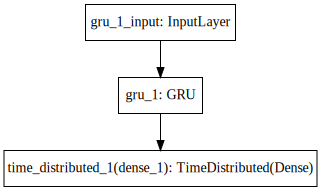

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Learn

In [17]:
class HDLoss(Callback):
    def on_train_begin(self, logs={}):
        self.exp = Experiment('[2.1.1] ChaRNN convergence', capture_io=False)
        
        # SUPER-hacky, but it's work (needed to supress hd output)
        self.exp._hd.out_buf.write = lambda _: _
    
    def on_train_end(self, logs={}):
        self.exp.end()

    def on_batch_end(self, n_batch, logs={}):
        self.exp.metric('n_batch', n_batch)
        self.exp.metric('loss', logs.get('loss'))

In [18]:
callbacks = [
    HDLoss(), 
    ModelCheckpoint(MODEL_PATH, 
                    monitor='loss', save_best_only=True)
]
model.fit_generator(TTSequence(), verbose=1, epochs=5,
                    callbacks=callbacks,
                    use_multiprocessing=False);

Epoch 1/5
2549/2674 [===========================>..] - ETA: 1:38 - loss: 0.6846

KeyboardInterrupt: 

## Test

In [ ]:
def generate_text(length, start):
    """Generate text with specific length."""
    assert length >= 1
    
    start = ', '.join(sorted(start)) + ' | '
    
    ys = list(start)
    X = np.zeros((1, len(start) + length, VOCAB_SIZE))
    for i in range(len(start)):
        X[0, i, dir_map[ys[i]]] = 1
    
    for i in range(len(start), len(start) + length):
        ix = np.argmax(model.predict(X[:, :i, :])[0], 1)[-1]
        X[0, i, ix] = 1
        ys.append(rev_map[ix])
    
    return ''.join(ys)[len(start):]

In [ ]:
generate_text(200, ['user', 'server'])